# Configurations

In [65]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import matplotlib as mpl

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

rc = {'text.color': 'black',
      'axes.labelcolor': 'black',
      'xtick.color': 'black',
      'ytick.color': 'black',
      'axes.edgecolor': 'black',
      'font.family': 'Helvetica',
      'figure.dpi': 72 * 2,
      'savefig.dpi': 72 * 4
      }
mpl.rcParams.update(rc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fig_dir=os.path.join(output_dir, 'figures/sfp_model/results_1D/nsdsyn')
precision_dir='/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision'

In [67]:
stim_classes=['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
roi_list=['V1','V2','V3']
lr = 0.005
max_epoch = 8000
subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
subj='subj02'
roi='V2'
voxels='pRFcenter'
stim_class='forward-spiral'

# eccentricity bin information
e1, e2=0.5, 4
enum=7
enum_range=range(7) if enum==7 else range(3) 
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, enum=enum)
ecc_colors = utils.get_continuous_colors(len(bin_labels)+1, '#3f0377')
ecc_colors = ecc_colors[1:][::-1]
ecc_colors = dict(zip(bin_labels, ecc_colors))

# Load the data and model parameters

In [10]:
f, m = [], []
for subj, roi in itertools.product(subj_list, roi_list):
    file_name = f'e1-{e1}_e2-{e2}_nbin-{enum}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'binned', file_name))

subj_df = utils.load_dataframes(f)
subj_df = subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']

pt_file_list = []
for subj, roi, curbin, stim_class in itertools.product(subj_list, roi_list, enum_range, stim_classes+['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
    
tuning_df = tuning.load_all_models(pt_file_list, *args)

# Plot tuning curves

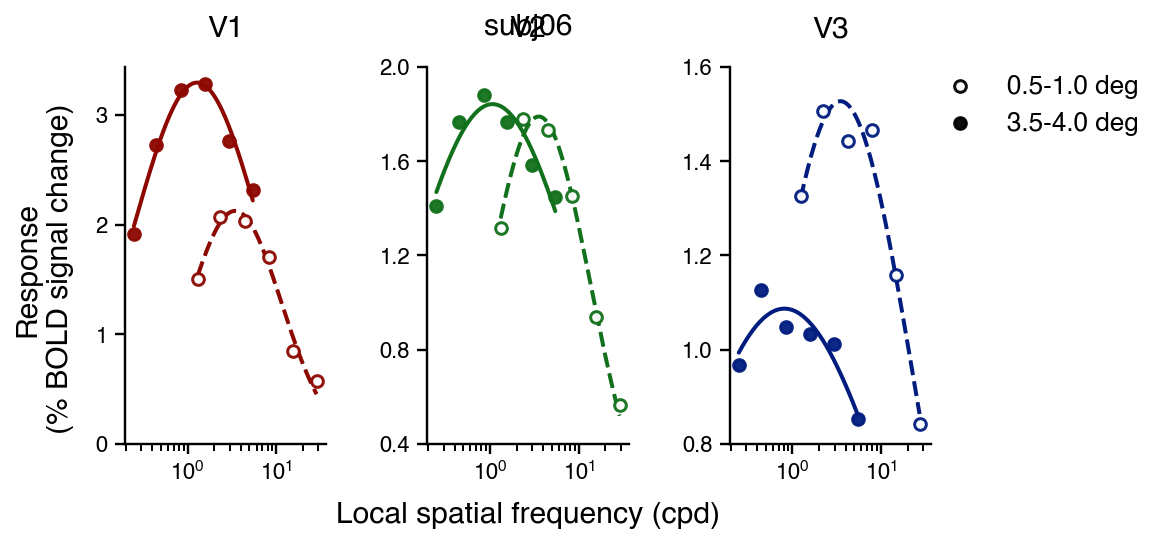

In [122]:
a = [3, 2, 0]
pal = [sns.color_palette('dark', 10)[:][k] for k in a]

bins_to_plot = [bin_labels[k] for k in [0,-1]]
stim_class = 'avg'
tmp_subj_df = subj_df.query('sub == "subj06"')
tmp_tuning_df = tuning_df.query('sub == "subj06" & names == @stim_class')
fig_name = os.path.join(output_dir,"figures", "sfp_model","results_1D", "nsdsyn", f'tuning_class_{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-all_dset-nsdsyn_sub-subj06_roi-all_vs-pRFsize.pdf')
g = vis1D.plot_sf_curves(df=tmp_subj_df, x='local_sf', y='betas', hue='ecc_bin', hue_order=bins_to_plot,
                         col='vroinames', params_df=tmp_tuning_df, lgd_title=None, palette=pal,
                         save_path=None)

# Plot preferred period as function of eccentricity

## Load in precision data

In [31]:
file_list = []
for subj, roi in itertools.product(subj_list, ['V1','V2','V3']):
    f = os.path.join(output_dir, 'dataframes', 'nsdsyn', 'precision', 
                     f'precision-v_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    file_list.append(f)
    
precision_v = utils.load_dataframes(file_list)
precision_s = precision_v.groupby(['sub','vroinames']).mean().reset_index()
precision_s['precision'] = 1 / precision_s['sigma_v_squared']

In [32]:
args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
pt_file_list = []
for subj, roi, curbin, stim_class in itertools.product(subj_list, roi_list, enum_range, ['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
tuning_df = tuning.load_all_models(pt_file_list, *args)

tuning_with_precision_df = tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
tuning_with_precision_df['pp'] = 1/ tuning_with_precision_df['mode']
fit_df = vis1D.fit_line_to_weighted_mean(tuning_with_precision_df, 'pp', 'precision', groupby=['vroinames'])

## Plot

In [54]:
sns.color_palette('dark',5)

[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.34901960784313724, 0.11764705882352941, 0.44313725490196076)]

In [63]:
a = [3,2,0]
pal = [sns.color_palette('dark', 10)[:][k] for k in a]
pal

[(0.5490196078431373, 0.03137254901960784, 0.0),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.0, 0.10980392156862745, 0.4980392156862745)]

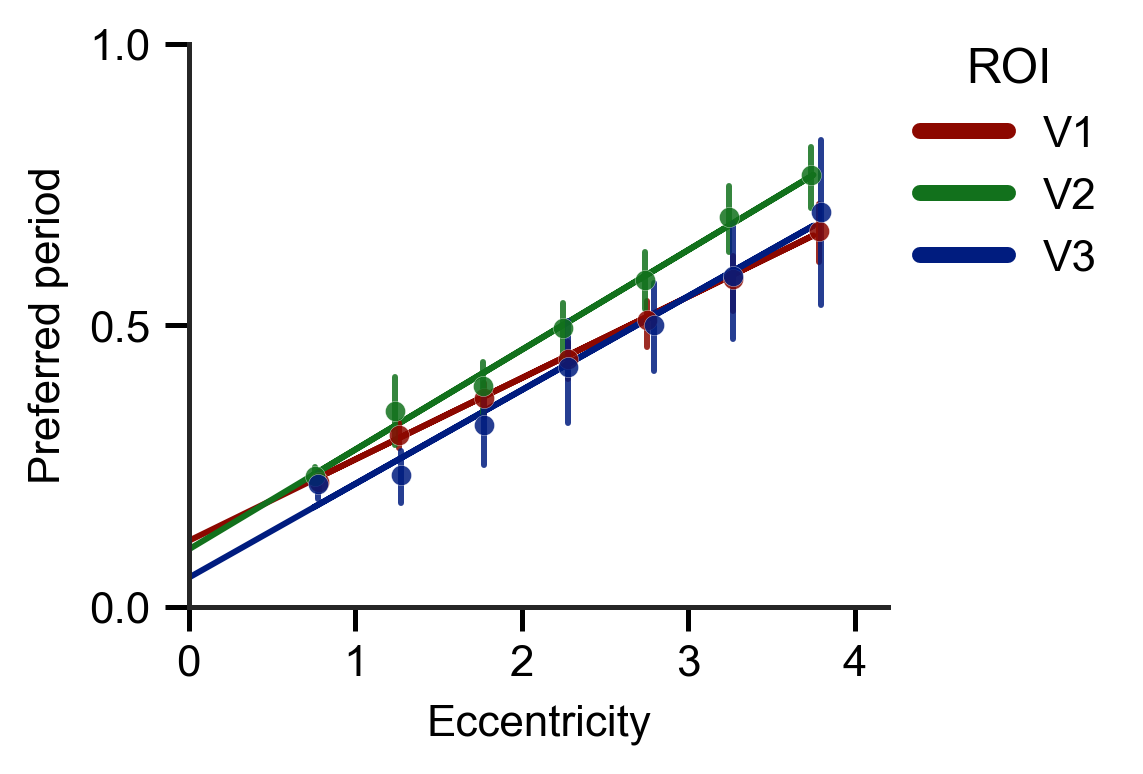

In [61]:
a = [3,2,0]
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in a]
g = vis1D.plot_preferred_period(tuning_with_precision_df, 
                                preferred_period='pp', precision='precision', hue='vroinames', 
                                hue_order=['V1','V2','V3'], fit_df=fit_df, lgd_title='ROI',
                                pal=roi_pal,
                                save_path=None)

# Plot Bandwidth as function of eccentricity

In [38]:
tuning_with_precision_df['fwhm'] = tuning_with_precision_df['sigma']*2.335
fit_bandwidth_df = vis1D.fit_line_to_weighted_mean(tuning_with_precision_df, 'fwhm', 'precision', groupby=['vroinames'])

In [39]:
fit_bandwidth_df

,vroinames,ecc,weighted_mean,coefficient,fitted
0,V1,0.75,5.397288,"[-0.022495646591712663, 5.380035800940004]",5.363164
1,V1,1.25,5.390347,"[-0.022495646591712663, 5.380035800940004]",5.351916
2,V1,1.75,5.301644,"[-0.022495646591712663, 5.380035800940004]",5.340668
3,V1,2.25,5.292820,"[-0.022495646591712663, 5.380035800940004]",5.329421
4,V1,2.75,5.255442,"[-0.022495646591712663, 5.380035800940004]",5.318173
5,V1,3.25,5.301387,"[-0.022495646591712663, 5.380035800940004]",5.306925
6,V1,3.75,5.367015,"[-0.022495646591712663, 5.380035800940004]",5.295677
7,V3,0.75,8.839407,"[-0.08545158013671893, 8.93368914644367]",8.869600
8,V3,1.25,9.056817,"[-0.08545158013671893, 8.93368914644367]",8.826875
9,V3,1.75,8.806555,"[-0.08545158013671893, 8.93368914644367]",8.784149


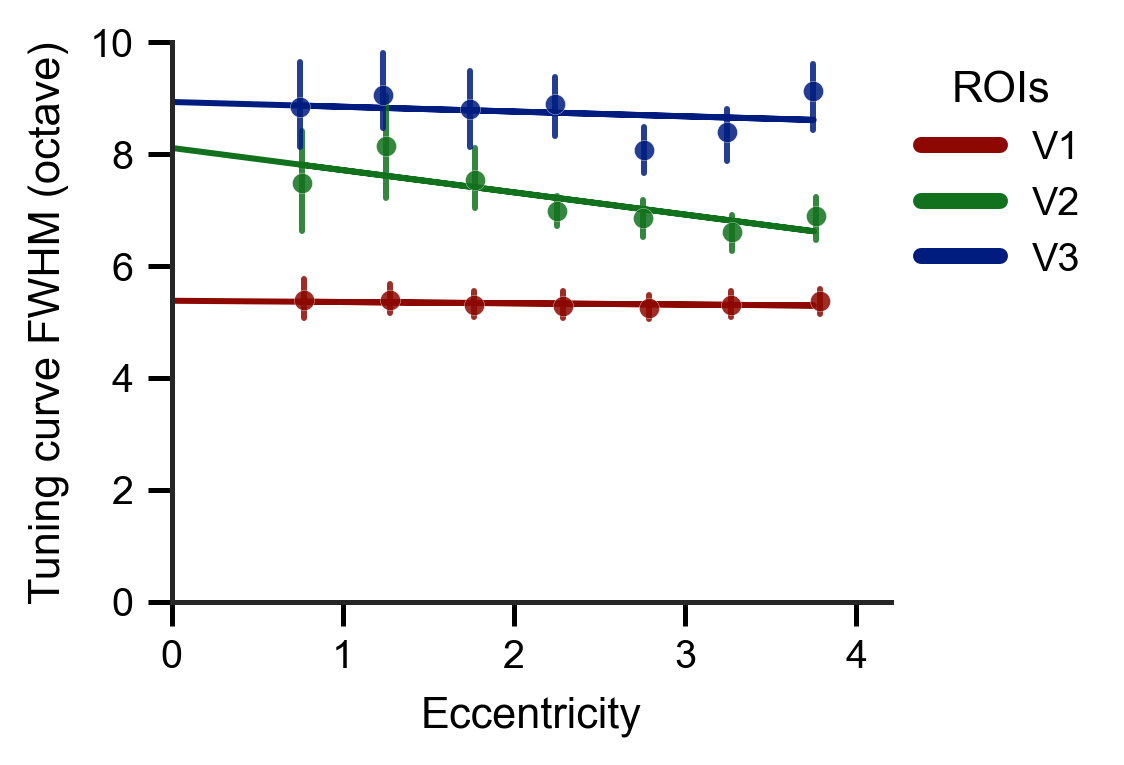

In [62]:
vis1D.plot_bandwidth_in_octave(tuning_with_precision_df, 
                               bandwidth='fwhm', precision='precision', 
                               hue='vroinames', hue_order=roi_list, 
                               fit_df=fit_bandwidth_df,
                               pal=roi_pal,
                               lgd_title='ROIs',
                               col=None, col_order=None,
                               suptitle=None, width=3.25, errorbar=("ci", 68),
                               save_path=None)